In [6]:
import mne
import os
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

# Directory paths
edf_dir = r'physionet.org/files/hmc-sleep-staging/1.0.0/recordings'  # Replace with the actual path to your EDF files
annotation_dir = r'physionet.org/files/hmc-sleep-staging/1.0.0/recordings'  # Replace with the actual path to your annotation files

# Initialize lists to store features and labels
all_wavelet_features = []
all_labels = []

# Define the wavelet transform function
def compute_wavelet_features(data, wavelet='db4', level=4):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    # Extract statistics from each wavelet level (mean, std deviation)
    features = [np.mean(c) for c in coeffs] + [np.std(c) for c in coeffs]
    return features

# Iterate over each EDF and annotation file pair
for i in range(1, 155):  # Adjust range for files from SN001 to SN154
    if i == 138:
        continue  # Skip SN138
    
    # Format the index to include leading zeros
    file_index = f'{i:03}'  # Ensures the file index has three digits, e.g., 001, 002, ..., 154
    edf_file = os.path.join(edf_dir, f'SN{file_index}.edf')
    annotation_file = os.path.join(annotation_dir, f'SN{file_index}_sleepscoring.txt')


    
    # Load EDF file
    raw = mne.io.read_raw_edf(edf_file, preload=True)
    raw.crop(tmin=150, tmax=raw.times[-1] - 150)  # Crop 150s from start and end
    raw.filter(0.5, 30, fir_design='firwin')  # Bandpass filter
    raw.resample(100)  # Resample

    # Load and process annotation file
    annotations_df = pd.read_csv(annotation_file)
    annotations_df.columns = ["Date", "Time", "Recording onset", "Duration", "Annotation", "Linked channel"]
    annotations_df['Recording onset'] = pd.to_numeric(annotations_df['Recording onset'], errors='coerce')
    annotations_df['Duration'] = pd.to_numeric(annotations_df['Duration'], errors='coerce')
    
    # Filter annotations to fit within the cropped data range and adjust onset
    total_duration = raw.times[-1] - 150 * 2
    filtered_annotations_df = annotations_df[
        (annotations_df['Recording onset'] >= 150) &
        (annotations_df['Recording onset'] <= total_duration)
    ].copy()
    filtered_annotations_df['Recording onset'] -= 150
    
    # Set annotations
    annotations = mne.Annotations(
        onset=filtered_annotations_df['Recording onset'].values,
        duration=filtered_annotations_df['Duration'].values,
        description=filtered_annotations_df['Annotation'].values
    )
    raw.set_annotations(annotations)
    
    # Create events and epochs
    events, event_id = mne.events_from_annotations(raw)
    epochs = mne.Epochs(raw, events, event_id, tmin=0, tmax=30, baseline=None, preload=True)
    
    # Encode labels
    labels = epochs.events[:, -1]
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    
    # Wavelet feature extraction
    eeg_data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_timepoints)
    wavelet_features = []
    for epoch in eeg_data:
        for channel_data in epoch:
            features = compute_wavelet_features(channel_data)
            wavelet_features.append(features)
    wavelet_features = np.array(wavelet_features)
    wavelet_features = wavelet_features.reshape(len(labels), -1)  # Reshape for ML input

    # Append to the main lists
    all_wavelet_features.extend(wavelet_features)
    all_labels.extend(labels)



Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6566399  =      0.000 ... 25649.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
830 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 830 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
832 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 832 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
930 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 930 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
992 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 992 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
935 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 935 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
842 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 842 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1010 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1010 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
823 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 823 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
877 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 877 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
900 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 900 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1117 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1117 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
913 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 913 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
980 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 980 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
700 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 700 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
843 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 843 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1064 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1064 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1090 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1090 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
838 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 838 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
816 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 816 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
924 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 924 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
932 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 932 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
978 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 978 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
767 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 767 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
833 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 833 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
966 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 966 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
859 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 859 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
848 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 848 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
878 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 878 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
927 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 927 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1032 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1032 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
749 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 749 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1164 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1164 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
498 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 498 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep S

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
863 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 863 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
972 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 972 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
784 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 784 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
806 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 806 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
903 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 903 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
863 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 863 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
777 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 777 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
813 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 813 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1126 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1126 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
990 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 990 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
947 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 947 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
691 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 691 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
687 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 687 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
860 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 860 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1232 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1232 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
777 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 777 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
908 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 908 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
905 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 905 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
987 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 987 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
916 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 916 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
474 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 474 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
971 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 971 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1129 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1129 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
752 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 752 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1025 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1025 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
802 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 802 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
918 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 918 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
838 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 838 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R')]
Not setting metadata
446 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 446 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep 

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1216 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1216 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
706 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 706 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1015 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1015 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
986 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 986 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
942 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 942 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
817 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 817 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
713 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 713 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
648 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 648 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1066 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1066 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1034 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1034 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
867 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 867 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
821 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 821 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1065 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1065 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
663 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 663 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
830 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 830 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
850 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 850 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1093 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1093 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
865 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 865 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1124 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1124 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
721 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 721 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1063 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1063 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
852 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 852 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
982 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 982 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
673 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 673 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
811 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 811 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
982 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 982 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
782 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 782 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
883 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 883 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
728 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 728 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1005 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1005 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
754 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 754 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1026 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1026 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
838 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 838 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
692 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 692 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1026 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1026 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
851 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 851 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
823 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 823 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
881 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 881 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
895 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 895 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
816 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 816 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
960 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 960 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
983 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 983 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
814 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 814 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
651 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 651 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
729 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 729 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
858 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 858 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
759 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 759 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
937 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 937 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1053 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1053 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage W')]
Not setting metadata
824 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 824 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep 

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
868 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 868 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
585 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 585 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
833 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 833 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
773 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 773 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
737 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 737 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
972 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 972 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
892 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 892 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
789 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 789 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1059 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1059 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
821 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 821 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
725 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 725 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1012 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1012 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1178 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1178 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
775 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 775 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
937 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 937 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
902 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 902 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
840 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 840 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
490 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 490 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
937 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 937 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
995 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 995 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
971 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 971 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1155 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1155 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
885 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 885 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep S

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
672 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 672 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1045 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1045 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
708 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 708 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1287 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1287 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1041 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1041 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
884 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 884 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
918 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 918 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
769 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 769 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
761 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 761 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
998 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 998 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
880 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 880 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
842 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 842 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
839 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 839 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
565 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 565 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
820 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 820 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
975 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 975 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
878 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 878 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3514950700.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
979 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 979 events and 3001 original time points ...
0 bad epochs dropped


Model training completed.
Accuracy: 0.7752846493342729
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.31      0.41      3119
           1       0.76      0.85      0.80      9994
           2       0.86      0.81      0.83      5280
           3       0.79      0.79      0.79      4269
           4       0.76      0.89      0.82      4301

    accuracy                           0.78     26963
   macro avg       0.76      0.73      0.73     26963
weighted avg       0.77      0.78      0.76     26963



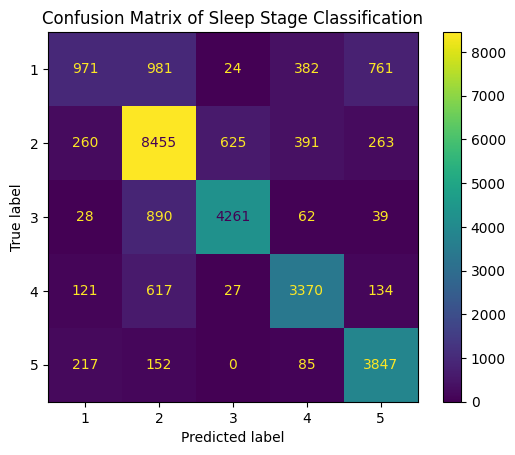

Cross-Validation Scores: [0.62596892 0.61213515 0.61265438 0.62926974 0.57640383]
Average CV Score: 0.6112864028767393


In [7]:
# Convert lists to arrays for ML
all_wavelet_features = np.array(all_wavelet_features)
all_labels = np.array(all_labels)

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(all_wavelet_features, all_labels, test_size=0.2, random_state=42)

# Initialize and train the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print("Model training completed.")

# Make predictions
y_pred = clf.predict(X_test)

# Display accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Display the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_encoder.classes_)
plt.title("Confusion Matrix of Sleep Stage Classification")
plt.show()

# 5-fold cross-validation
cv_scores_rf = cross_val_score(clf, all_wavelet_features, all_labels, cv=5)
print("Cross-Validation Scores:", cv_scores_rf)
print("Average CV Score:", np.mean(cv_scores_rf))


In [8]:
#!pip install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Nadam

# Define the model
model = Sequential([
    Dense(256, activation='relu', input_shape=(all_wavelet_features.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(len(label_encoder.classes_), activation='softmax')  # One output per sleep stage
])

# Compile the model
model.compile(optimizer=Nadam(learning_rate=0.001),  # Adjust learning rate if necessary
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.25,
                    callbacks=[early_stopping])

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)


c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\sleep_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.3284 - loss: 1.6411 - val_accuracy: 0.3941 - val_loss: 1.5533
Epoch 2/100
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.5250 - loss: 1.1595 - val_accuracy: 0.6163 - val_loss: 0.9941
Epoch 3/100
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.5746 - loss: 1.0805 - val_accuracy: 0.5946 - val_loss: 1.0142
Epoch 4/100
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.5893 - loss: 1.0459 - val_accuracy: 0.5874 - val_loss: 1.0613
Epoch 5/100
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5954 - loss: 1.0200 - val_accuracy: 0.2253 - val_loss: 2.7068
Epoch 6/100
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5992 - loss: 1.0110 - val_accuracy: 0.5442 - val_loss: 1.3167
Epoch 7/100
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6054 - loss: 0.9920 - val_accuracy: 0.3967 - val_loss: 1.4530
Epoch 8/100
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6079 - loss

In [9]:
print("Features shape:", all_wavelet_features.shape)
print("Labels shape:", labels.shape)


Features shape: (134814, 80)
Labels shape: (979,)


c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\sleep_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:35:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model training completed.
Accuracy: 0.7976115417423877
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.42      0.48      3119
           1       0.79      0.85      0.82      9994
           2       0.86      0.83      0.84      5280
           3       0.84      0.84      0.84      4269
           4       0.82      0.88      0.85      4301

    accuracy                           0.80     26963
   macro avg       0.78      0.76      0.77     26963
weighted avg       0.79      0.80      0.79     26963



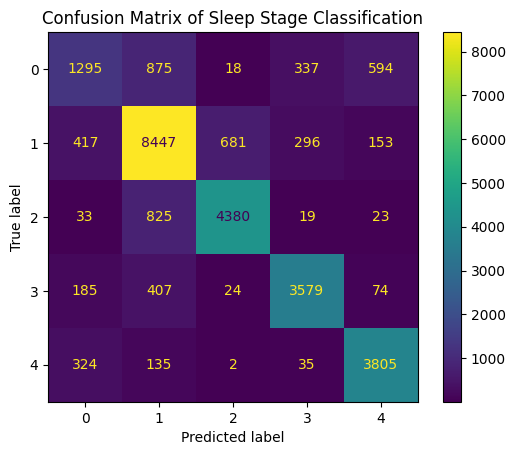

c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\sleep_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:35:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\sleep_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:35:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\sleep_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:35:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c03137

Cross-Validation Scores: [0.68104439 0.67099358 0.65371064 0.67755814 0.64720718]
Average CV Score: 0.666102786835148


In [13]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Convert to NumPy arrays
all_wavelet_features = np.array(all_wavelet_features)
all_labels = np.array(all_labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(all_wavelet_features, all_labels, test_size=0.2, random_state=42)

# Initialize and train the XGBoost classifier
clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
clf.fit(X_train, y_train)
print("Model training completed.")

# Make predictions
y_pred = clf.predict(X_test)

# Display accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Display the confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=np.unique(all_labels))
plt.title("Confusion Matrix of Sleep Stage Classification")
plt.show()

# 5-fold cross-validation
cv_scores_xgb = cross_val_score(clf, all_wavelet_features, all_labels, cv=5)
print("Cross-Validation Scores:", cv_scores_xgb)
print("Average CV Score:", np.mean(cv_scores_xgb))


In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(all_wavelet_features, all_labels, test_size=0.2, random_state=42)

# Initialize and train the k-NN classifier
clf = KNeighborsClassifier(n_neighbors=5)  # You can adjust n_neighbors
clf.fit(X_train, y_train)
print("Model training completed.")

# Make predictions
y_pred = clf.predict(X_test)

# Display accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

cv_scores_knn = cross_val_score(clf, all_wavelet_features, all_labels, cv=5)
print("Cross-Validation Scores:", cv_scores_knn)
print("Average CV Score:", np.mean(cv_scores_knn))



Model training completed.
Accuracy: 0.704854801023625
Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.36      0.38      3119
           1       0.71      0.79      0.75      9994
           2       0.77      0.82      0.79      5280
           3       0.74      0.68      0.71      4269
           4       0.79      0.65      0.71      4301

    accuracy                           0.70     26963
   macro avg       0.68      0.66      0.67     26963
weighted avg       0.70      0.70      0.70     26963

Cross-Validation Scores: [0.46604606 0.43748841 0.43307495 0.46018618 0.43446332]
Average CV Score: 0.44625178550842814


In [18]:
from scipy import stats
mean_rf, std_rf = np.mean(cv_scores_rf), np.std(cv_scores_rf, ddof=1)
mean_xgb, std_xgb = np.mean(cv_scores_xgb), np.std(cv_scores_xgb, ddof=1)
mean_knn, std_knn = np.mean(cv_scores_knn), np.std(cv_scores_knn, ddof=1)

# Calculate Z-scores for each model pair
def z_test(mean1, std1, mean2, std2, n):
    z_score = (mean1 - mean2) / np.sqrt((std1**2 + std2**2) / n)
    p_value = stats.norm.sf(abs(z_score)) * 2  # Two-tailed test
    return z_score, p_value

n = 5  # Number of cross-validation folds

# Z-test between Random Forest and XGBoost
z_rf_xgb, p_rf_xgb = z_test(mean_rf, std_rf, mean_xgb, std_xgb, n)
print(f"Random Forest vs XGBoost: Z = {z_rf_xgb:.3f}, p = {p_rf_xgb:.3f}")

# Z-test between Random Forest and KNN
z_rf_knn, p_rf_knn = z_test(mean_rf, std_rf, mean_knn, std_knn, n)
print(f"Random Forest vs KNN: Z = {z_rf_knn:.3f}, p = {p_rf_knn:.3f}")

# Z-test between XGBoost and KNN
z_xgb_knn, p_xgb_knn = z_test(mean_xgb, std_xgb, mean_knn, std_knn, n)
print(f"XGBoost vs KNN: Z = {z_xgb_knn:.3f}, p = {p_xgb_knn:.3f}")

Random Forest vs XGBoost: Z = -4.765, p = 0.000
Random Forest vs KNN: Z = 14.116, p = 0.000
XGBoost vs KNN: Z = 22.771, p = 0.000


In [19]:
t_stat_rf_xgb, p_value_rf_xgb = stats.ttest_rel(cv_scores_rf, cv_scores_xgb)
print(f"Random Forest vs XGBoost: t = {t_stat_rf_xgb:.3f}, p = {p_value_rf_xgb:.3f}")

# Paired t-test between Random Forest and KNN
t_stat_rf_knn, p_value_rf_knn = stats.ttest_rel(cv_scores_rf, cv_scores_knn)
print(f"Random Forest vs KNN: t = {t_stat_rf_knn:.3f}, p = {p_value_rf_knn:.3f}")

# Paired t-test between XGBoost and KNN
t_stat_xgb_knn, p_value_xgb_knn = stats.ttest_rel(cv_scores_xgb, cv_scores_knn)
print(f"XGBoost vs KNN: t = {t_stat_xgb_knn:.3f}, p = {p_value_xgb_knn:.3f}")

Random Forest vs XGBoost: t = -10.920, p = 0.000
Random Forest vs KNN: t = 24.883, p = 0.000
XGBoost vs KNN: t = 60.142, p = 0.000


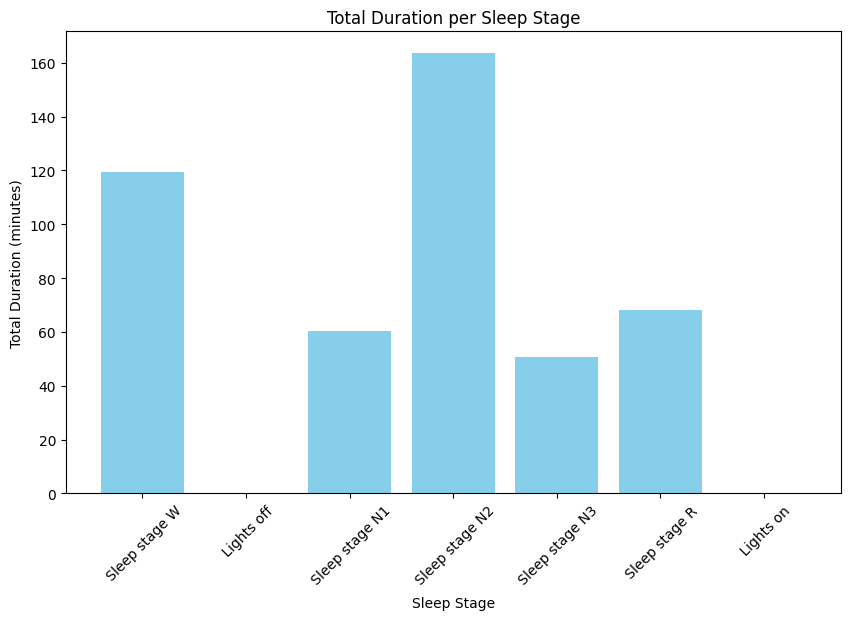

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Path to the annotation directory
annotation_dir = r'physionet.org/files/hmc-sleep-staging/1.0.0/recordings'

# Initialize a dictionary to store total durations per sleep stage
sleep_stage_durations = {}

# Iterate over each annotation file to calculate the duration per sleep stage
for i in range(10,11):  # Adjust range based on available files
    annotation_file = os.path.join(annotation_dir, f'SN0{i}_sleepscoring.txt')
    
    # Load and process the annotation file
    annotations_df = pd.read_csv(annotation_file, header=None)
    annotations_df.columns = ["Date", "Time", "Recording onset", "Duration", "Annotation", "Linked channel"]
    annotations_df['Recording onset'] = pd.to_numeric(annotations_df['Recording onset'], errors='coerce')
    annotations_df['Duration'] = pd.to_numeric(annotations_df['Duration'], errors='coerce')
    # Sum up durations per sleep stage
    for _, row in annotations_df.iterrows():
        stage = row["Annotation"]
        duration = row["Duration"]
        if stage not in ['Lights off','Lights on']:
            if stage in sleep_stage_durations:
                sleep_stage_durations[stage] += duration
            else:
                sleep_stage_durations[stage] = duration

# Convert durations to minutes (assuming they are in seconds)
sleep_stage_durations = {stage: duration / 60 for stage, duration in sleep_stage_durations.items()}

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(sleep_stage_durations.keys(), sleep_stage_durations.values(), color='skyblue')
plt.xlabel("Sleep Stage")
plt.ylabel("Total Duration (minutes)")
plt.title("Total Duration per Sleep Stage")
plt.xticks(rotation=45)
plt.show()


In [42]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
all_wavelet_features = scaler.fit_transform(all_wavelet_features)




c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\sleep_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:09:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model training completed.
Accuracy: 0.7972035752698142
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.42      0.49      3119
           1       0.80      0.84      0.82      9994
           2       0.86      0.83      0.85      5280
           3       0.81      0.84      0.82      4269
           4       0.82      0.88      0.85      4301

    accuracy                           0.80     26963
   macro avg       0.77      0.76      0.77     26963
weighted avg       0.79      0.80      0.79     26963



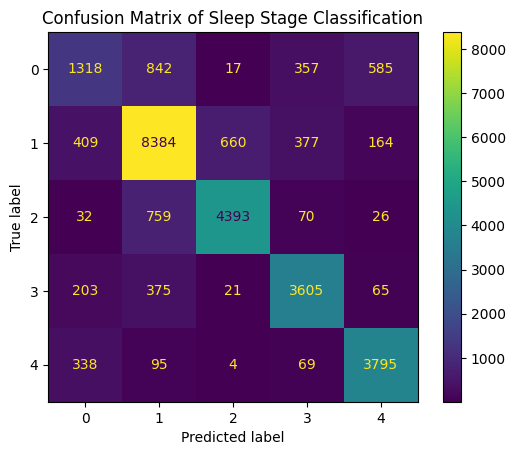

c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\sleep_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:10:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\sleep_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:10:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\sleep_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:11:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c03137

Cross-Validation Scores: [0.67600045 0.67659385 0.65167081 0.67588918 0.64590906]
Average CV Score: 0.6652126685387916


In [43]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Convert to NumPy arrays
all_wavelet_features = np.array(all_wavelet_features)
all_labels = np.array(all_labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(all_wavelet_features, all_labels, test_size=0.2, random_state=42)

# Initialize and train the XGBoost classifier
clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
clf.fit(X_train, y_train)
print("Model training completed.")

# Make predictions
y_pred = clf.predict(X_test)

# Display accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Display the confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=np.unique(all_labels))
plt.title("Confusion Matrix of Sleep Stage Classification")
plt.show()

# 5-fold cross-validation
cv_scores_xgb = cross_val_score(clf, all_wavelet_features, all_labels, cv=5)
print("Cross-Validation Scores:", cv_scores_xgb)
print("Average CV Score:", np.mean(cv_scores_xgb))



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\sleep_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:59:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model training completed with SMOTE.
Accuracy: 0.7807365649223009
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.56      0.53      3119
           1       0.85      0.73      0.79      9994
           2       0.80      0.87      0.83      5280
           3       0.79      0.86      0.82      4269
           4       0.83      0.88      0.85      4301

    accuracy                           0.78     26963
   macro avg       0.75      0.78      0.76     26963
weighted avg       0.79      0.78      0.78     26963



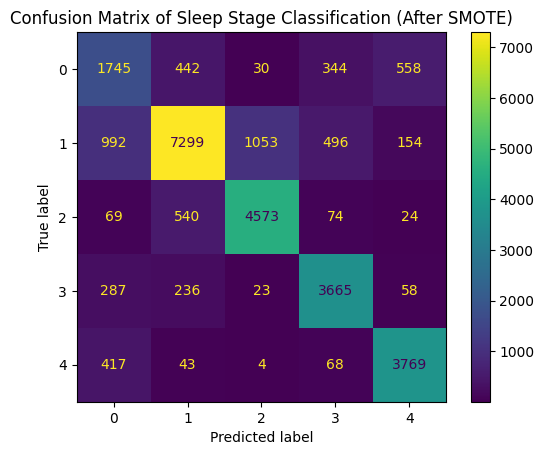

In [35]:
!pip install imblearn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(all_wavelet_features, all_labels, test_size=0.2, random_state=42)

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize and train the XGBoost classifier
clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
clf.fit(X_train_resampled, y_train_resampled)
print("Model training completed with SMOTE.")

# Make predictions
y_pred = clf.predict(X_test)

# Display accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Display the confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=np.unique(all_labels))
plt.title("Confusion Matrix of Sleep Stage Classification (After SMOTE)")
plt.show()


In [36]:
cv_scores_xgb = cross_val_score(clf, all_wavelet_features, all_labels, cv=5)
print("Cross-Validation Scores:", cv_scores_xgb)
print("Average CV Score:", np.mean(cv_scores_xgb))

c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\sleep_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:02:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\sleep_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:02:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\sleep_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:02:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c03137

Cross-Validation Scores: [0.67600045 0.67659385 0.65167081 0.67588918 0.64590906]
Average CV Score: 0.6652126685387916


Accuracy: 0.5745651448280977
Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.42      0.34      3119
           1       0.65      0.53      0.59      9994
           2       0.67      0.61      0.64      5280
           3       0.55      0.63      0.59      4269
           4       0.67      0.68      0.67      4301

    accuracy                           0.57     26963
   macro avg       0.56      0.58      0.56     26963
weighted avg       0.60      0.57      0.58     26963



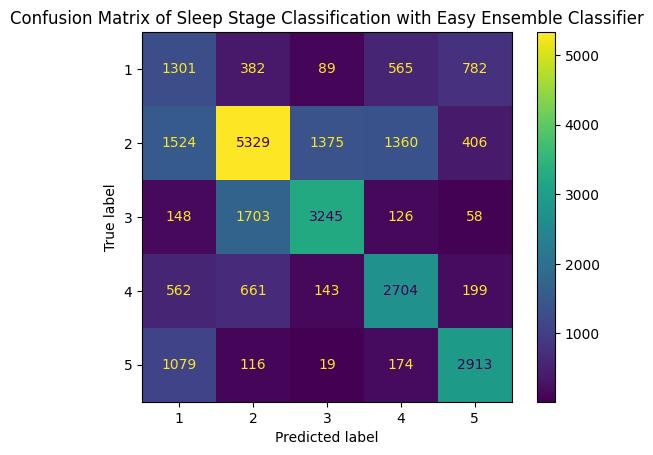

Cross-Validation Scores: [0.5496421  0.57586322 0.56392093 0.58791677 0.56872636]
Average CV Score: 0.5692138762478628


In [38]:
# %% Import required libraries
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define and train the Easy Ensemble Classifier
eec_clf = EasyEnsembleClassifier(n_estimators=10, random_state=42)  # Adjust n_estimators as needed
eec_clf.fit(X_train, y_train)

# Make predictions
y_pred_eec = eec_clf.predict(X_test)

# Display accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred_eec))
print("Classification Report:\n", classification_report(y_test, y_pred_eec))

# Display the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_eec, display_labels=label_encoder.classes_)
plt.title("Confusion Matrix of Sleep Stage Classification with Easy Ensemble Classifier")
plt.show()

# Perform 5-fold cross-validation
cv_scores_eec = cross_val_score(eec_clf, all_wavelet_features, all_labels, cv=5)
print("Cross-Validation Scores:", cv_scores_eec)
print("Average CV Score:", np.mean(cv_scores_eec))


c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\sleep_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5051 - loss: 1.2274 - val_accuracy: 0.6674 - val_loss: 0.8472
Epoch 2/100
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6205 - loss: 0.9495 - val_accuracy: 0.6806 - val_loss: 0.8031
Epoch 3/100
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6410 - loss: 0.8921 - val_accuracy: 0.6991 - val_loss: 0.7720
Epoch 4/100
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6556 - loss: 0.8698 - val_accuracy: 0.7108 - val_loss: 0.7499
Epoch 5/100
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6651 - loss: 0.8476 - val_accuracy: 0.7049 - val_loss: 0.7651
Epoch 6/100
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6700 - loss: 0.8350 - val_accuracy: 0.7089 - val_loss: 0.7460
Epoch 7/100
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.6752 - loss: 0.8231 - val_accuracy: 0.7162 - val_loss: 0.7323
Epoch 8/100
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6769 -

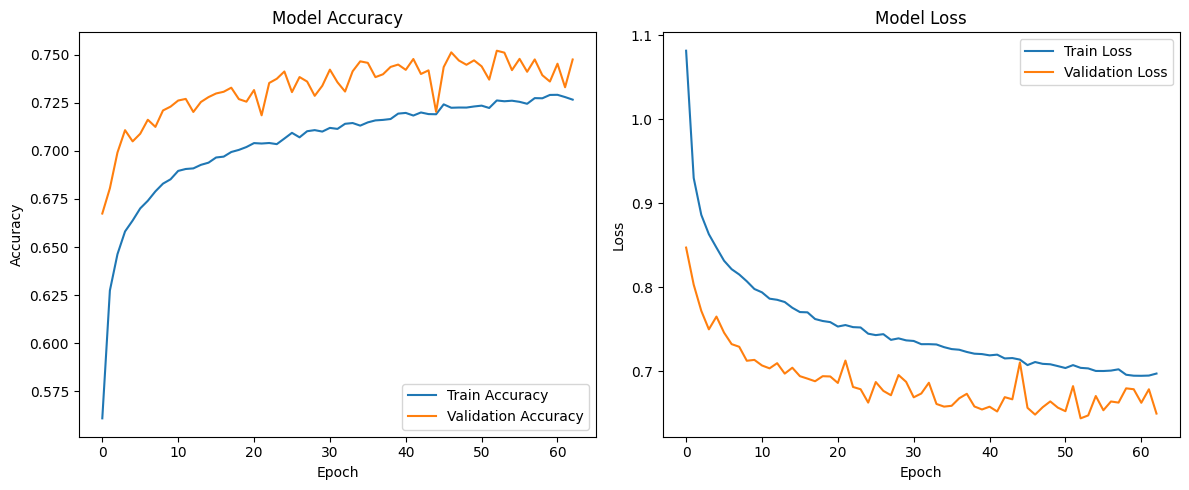

In [44]:
from tensorflow.keras.optimizers import SGD

# Define the model
model = Sequential([
    Dense(256, activation='relu', input_shape=(all_wavelet_features.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(len(label_encoder.classes_), activation='softmax')  # One output per sleep stage
])

# Compile the model with SGD optimizer
model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9),  # Adjust learning rate and momentum if necessary
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.25,
                    callbacks=[early_stopping])

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


843/843 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


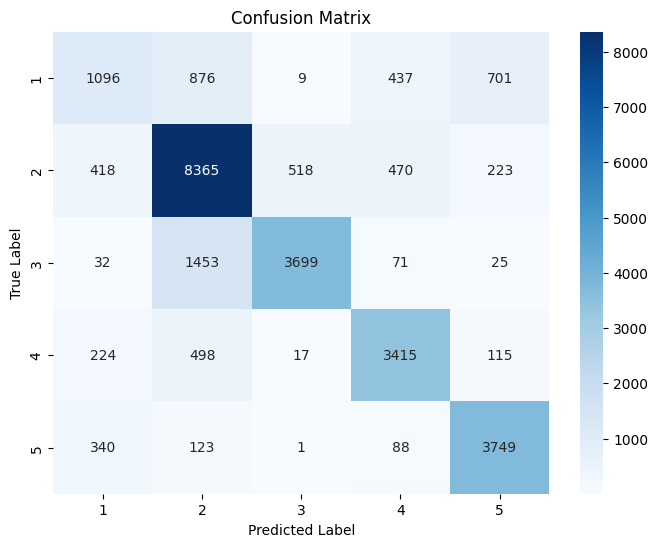

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Predict the classes for the test set
y_pred = np.argmax(model.predict(X_test), axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


Epoch 1/100
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.5348 - loss: 1.1692 - val_accuracy: 0.6811 - val_loss: 0.8068
Epoch 2/100
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6434 - loss: 0.8932 - val_accuracy: 0.7046 - val_loss: 0.7539
Epoch 3/100
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6703 - loss: 0.8445 - val_accuracy: 0.7175 - val_loss: 0.7291
Epoch 4/100
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6781 - loss: 0.8183 - val_accuracy: 0.7160 - val_loss: 0.7236
Epoch 5/100
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6861 - loss: 0.7995 - val_accuracy: 0.7063 - val_loss: 0.7282
Epoch 6/100
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6932 - loss: 0.7859 - val_accuracy: 0.7079 - val_loss: 0.7295
Epoch 7/100
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6946 - loss: 0.7775 - val_accuracy: 0.7284 - val_loss: 0.6953
Epoch 8/100
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6988 - loss: 0

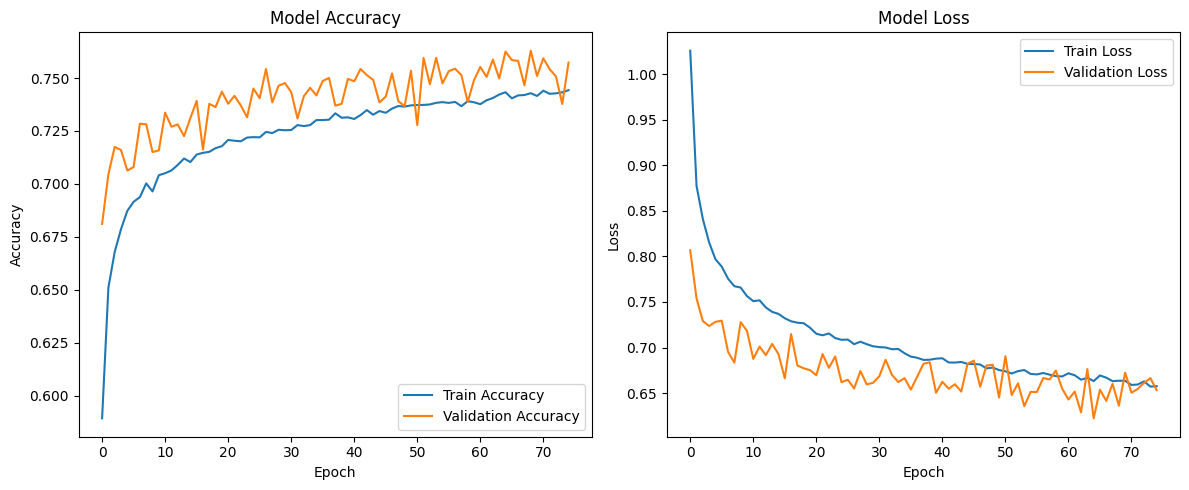

In [ ]:
from tensorflow.keras.optimizers import Adamax
import matplotlib.pyplot as plt

# Define the model
model = Sequential([
    Dense(256, activation='relu', input_shape=(all_wavelet_features.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(len(label_encoder.classes_), activation='softmax')  
])

# Compile the model with Adamax optimizer
model.compile(optimizer=Adamax(learning_rate=0.01),  
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.25,
                    callbacks=[early_stopping])

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6566399  =      0.000 ... 25649.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6577407  =      0.000 ... 25692.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7330815  =      0.000 ... 28635.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7804927  =      0.000 ... 30487.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7370751  =      0.000 ... 28791.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6655487  =      0.000 ... 25997.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7944191  =      0.000 ... 31031.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6508031  =      0.000 ... 25421.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6922751  =      0.000 ... 27041.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7099647  =      0.000 ... 27732.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8763391  =      0.000 ... 34231.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7203839  =      0.000 ... 28139.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7714303  =      0.000 ... 30133.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5561087  =      0.000 ... 21722.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6663679  =      0.000 ... 26029.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8356351  =      0.000 ... 32641.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN017.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8560895  =      0.000 ... 33440.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN018.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6621439  =      0.000 ... 25864.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN019.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6456575  =      0.000 ... 25220.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN020.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7283711  =      0.000 ... 28451.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN021.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7344383  =      0.000 ... 28688.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN022.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7696127  =      0.000 ... 30062.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN023.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6081023  =      0.000 ... 23753.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN024.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6582527  =      0.000 ... 25712.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN025.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7603455  =      0.000 ... 29700.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN026.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6781695  =      0.000 ... 26490.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN027.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6702079  =      0.000 ... 26179.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN028.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6927615  =      0.000 ... 27060.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN029.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7308799  =      0.000 ... 28549.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN030.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8111359  =      0.000 ... 31684.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN031.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5936895  =      0.000 ... 23190.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN032.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9124863  =      0.000 ... 35643.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN033.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4012543  =      0.000 ... 15673.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN034.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6815487  =      0.000 ... 26622.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN035.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7649535  =      0.000 ... 29880.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN036.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6207487  =      0.000 ... 24247.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN037.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6375423  =      0.000 ... 24903.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN038.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7119615  =      0.000 ... 27810.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN039.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6819071  =      0.000 ... 26636.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN040.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6153471  =      0.000 ... 24036.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN041.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6428671  =      0.000 ... 25111.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN042.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8837375  =      0.000 ... 34520.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN043.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7791615  =      0.000 ... 30435.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN044.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7461887  =      0.000 ... 29147.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN045.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5496831  =      0.000 ... 21471.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN046.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5467135  =      0.000 ... 21355.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN047.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6796799  =      0.000 ... 26549.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN048.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9647615  =      0.000 ... 37685.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN049.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6152447  =      0.000 ... 24032.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN050.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7161087  =      0.000 ... 27972.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN051.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7136255  =      0.000 ... 27875.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN052.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7768063  =      0.000 ... 30343.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN053.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7220223  =      0.000 ... 28203.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN054.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3831551  =      0.000 ... 14966.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN055.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7644415  =      0.000 ... 29860.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN056.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8862719  =      0.000 ... 34619.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN057.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5963263  =      0.000 ... 23293.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN058.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8056575  =      0.000 ... 31470.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN059.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6343935  =      0.000 ... 24780.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN060.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7241215  =      0.000 ... 28285.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN061.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6627327  =      0.000 ... 25887.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN062.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3610623  =      0.000 ... 14103.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN063.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9524735  =      0.000 ... 37205.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN064.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5613823  =      0.000 ... 21928.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN065.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7982847  =      0.000 ... 31182.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN066.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7761919  =      0.000 ... 30319.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN067.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7420671  =      0.000 ... 28986.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN068.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6462719  =      0.000 ... 25244.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN069.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5667583  =      0.000 ... 22138.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN070.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5162239  =      0.000 ... 20164.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN071.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8372223  =      0.000 ... 32703.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN072.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8125951  =      0.000 ... 31741.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN073.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6843135  =      0.000 ... 26730.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN074.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6490367  =      0.000 ... 25352.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN075.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8364287  =      0.000 ... 32672.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN076.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5278207  =      0.000 ... 20617.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN077.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6562559  =      0.000 ... 25634.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN078.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6714111  =      0.000 ... 26226.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN079.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8583679  =      0.000 ... 33529.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN080.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6827775  =      0.000 ... 26670.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN081.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8824063  =      0.000 ... 34468.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN082.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5723135  =      0.000 ... 22355.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN083.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8355071  =      0.000 ... 32636.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN084.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6735103  =      0.000 ... 26308.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN085.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7728639  =      0.000 ... 30189.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN086.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5357055  =      0.000 ... 20925.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN087.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6419967  =      0.000 ... 25077.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN088.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7730431  =      0.000 ... 30196.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN089.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6193151  =      0.000 ... 24191.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN090.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6966015  =      0.000 ... 27210.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN091.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5776895  =      0.000 ... 22565.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN092.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7906559  =      0.000 ... 30884.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN093.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5975295  =      0.000 ... 23340.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN094.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8064255  =      0.000 ... 31500.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN095.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6621439  =      0.000 ... 25864.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN096.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5502463  =      0.000 ... 21493.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN097.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8066047  =      0.000 ... 31507.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN098.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6720767  =      0.000 ... 26252.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN099.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6506495  =      0.000 ... 25415.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN100.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6951679  =      0.000 ... 27154.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN101.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7065087  =      0.000 ... 27597.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN102.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6457087  =      0.000 ... 25222.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN103.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7559423  =      0.000 ... 29528.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN104.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7739647  =      0.000 ... 30232.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN105.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6442495  =      0.000 ... 25165.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN106.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5185023  =      0.000 ... 20253.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN107.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5789439  =      0.000 ... 22614.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN108.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6774015  =      0.000 ... 26460.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN109.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6013695  =      0.000 ... 23490.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN110.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7381247  =      0.000 ... 28832.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN111.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8273407  =      0.000 ... 32317.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN112.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6513407  =      0.000 ... 25442.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN113.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6854143  =      0.000 ... 26773.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN114.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4679423  =      0.000 ... 18278.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN115.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6582783  =      0.000 ... 25713.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN116.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6127103  =      0.000 ... 23933.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN117.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5848319  =      0.000 ... 22844.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN118.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7649791  =      0.000 ... 29881.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN119.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7038719  =      0.000 ... 27494.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN120.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6244095  =      0.000 ... 24390.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN121.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8325119  =      0.000 ... 32519.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN122.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6494463  =      0.000 ... 25368.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN123.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5757695  =      0.000 ... 22490.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN124.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7960319  =      0.000 ... 31094.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN125.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9231615  =      0.000 ... 36060.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN126.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6143743  =      0.000 ... 23998.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN127.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7383295  =      0.000 ... 28840.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN128.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7117823  =      0.000 ... 27803.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN129.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6637311  =      0.000 ... 25926.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN130.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3951359  =      0.000 ... 15434.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN131.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7386623  =      0.000 ... 28853.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN132.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7829247  =      0.000 ... 30582.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN133.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7642623  =      0.000 ... 29853.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN134.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9054975  =      0.000 ... 35370.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN135.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6984959  =      0.000 ... 27284.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN136.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5350143  =      0.000 ... 20898.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN137.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8214271  =      0.000 ... 32086.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN139.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5622015  =      0.000 ... 21960.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN140.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10073343  =      0.000 ... 39348.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN141.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8182271  =      0.000 ... 31961.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN142.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6980863  =      0.000 ... 27268.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN143.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7236607  =      0.000 ... 28267.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN144.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6090751  =      0.000 ... 23791.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN145.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6036223  =      0.000 ... 23578.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN146.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7849471  =      0.000 ... 30661.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN147.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6948095  =      0.000 ... 27140.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN148.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6655231  =      0.000 ... 25996.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN149.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6634495  =      0.000 ... 25915.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN150.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4528383  =      0.000 ... 17688.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN151.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6486527  =      0.000 ... 25337.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN152.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7675135  =      0.000 ... 29980.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN153.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6927871  =      0.000 ... 27061.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN154.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7708415  =      0.000 ... 30110.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3265431481.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)



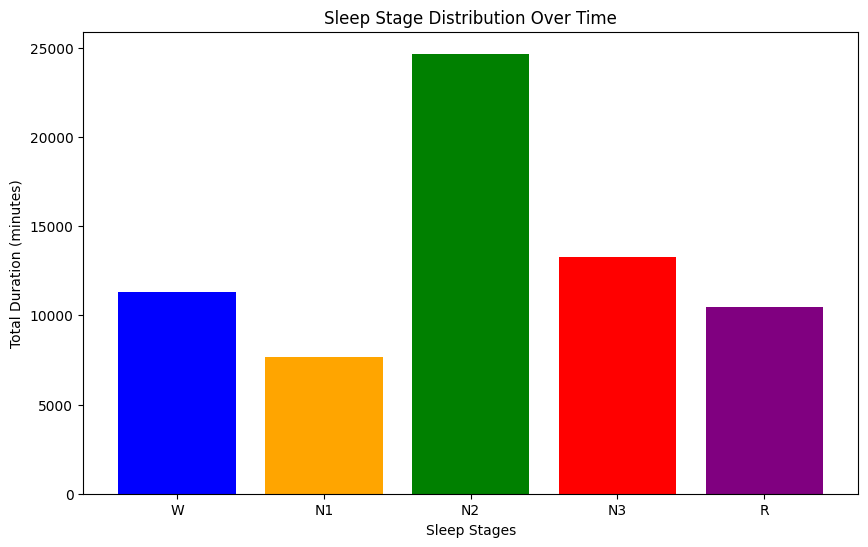

In [49]:
# Initialize a dictionary to accumulate sleep stage durations
sleep_stage_durations = {
    "W": 0,
    "N1": 0,
    "N2": 0,
    "N3": 0,
    "R": 0
}

# Loop through files as in your original code
for i in range(1, 155):  # Adjust range for files from SN001 to SN154
    if i == 138:
        continue  # Skip SN138

    # Format the index to include leading zeros
    file_index = f'{i:03}'
    edf_file = os.path.join(edf_dir, f'SN{file_index}.edf')
    annotation_file = os.path.join(annotation_dir, f'SN{file_index}_sleepscoring.txt')

    # Load EDF file and preprocess
    raw = mne.io.read_raw_edf(edf_file, preload=True)
    raw.crop(tmin=150, tmax=raw.times[-1] - 150)
    raw.filter(0.5, 30, fir_design='firwin')
    raw.resample(100)

    # Load and process annotation file
    annotations_df = pd.read_csv(annotation_file)
    annotations_df.columns = ["Date", "Time", "Recording onset", "Duration", "Annotation", "Linked channel"]
    annotations_df['Recording onset'] = pd.to_numeric(annotations_df['Recording onset'], errors='coerce')
    annotations_df['Duration'] = pd.to_numeric(annotations_df['Duration'], errors='coerce')

    # Filter annotations to fit within the cropped data range and adjust onset
    total_duration = raw.times[-1] - 150 * 2
    filtered_annotations_df = annotations_df[
        (annotations_df['Recording onset'] >= 150) &
        (annotations_df['Recording onset'] <= total_duration)
    ].copy()
    filtered_annotations_df['Recording onset'] -= 150

    # Accumulate duration for each sleep stage
    for _, row in filtered_annotations_df.iterrows():
        stage = row['Annotation'].split()[-1]  # Extract the sleep stage (e.g., "W", "N1", "N2", "N3", "R")
        if stage in sleep_stage_durations:
            sleep_stage_durations[stage] += row['Duration']

# Plot sleep stage distribution
import matplotlib.pyplot as plt

# Convert accumulated durations from seconds to minutes
sleep_stage_durations = {stage: duration / 60 for stage, duration in sleep_stage_durations.items()}

# Plot
plt.figure(figsize=(10, 6))
plt.bar(sleep_stage_durations.keys(), sleep_stage_durations.values(), color=['blue', 'orange', 'green', 'red', 'purple'])
plt.xlabel('Sleep Stages')
plt.ylabel('Total Duration (minutes)')
plt.title('Sleep Stage Distribution Over Time')
plt.show()


Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7370751  =      0.000 ... 28791.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\2408005955.py:20: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Sleep Efficiency for SN005: 79.68%
Deep Sleep Percentage for SN005: 15.94%


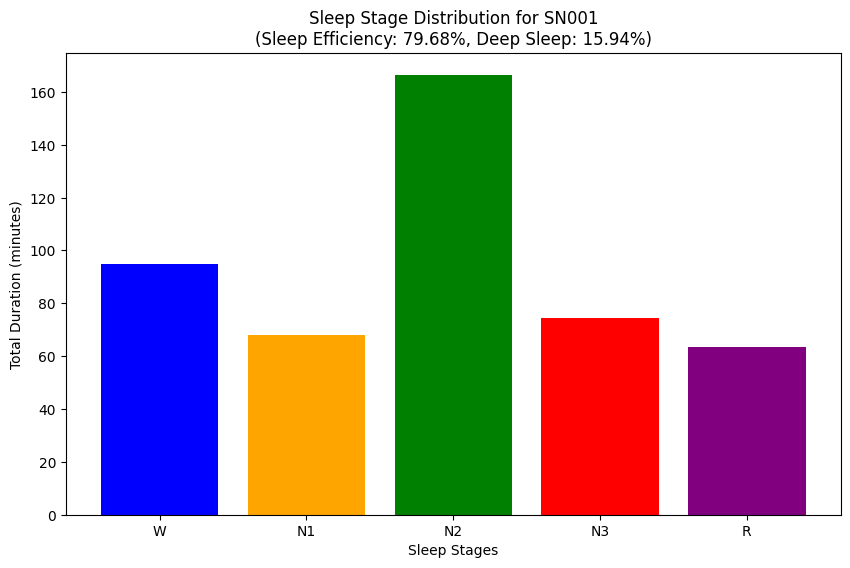

In [65]:
import os
import mne
import pandas as pd
import matplotlib.pyplot as plt

# Define file paths for SN001
edf_file = os.path.join(edf_dir, 'SN005.edf')
annotation_file = os.path.join(annotation_dir, 'SN005_sleepscoring.txt')

# Initialize a dictionary to accumulate sleep stage durations for SN001
sleep_stage_durations = {
    "W": 0,
    "N1": 0,
    "N2": 0,
    "N3": 0,
    "R": 0
}

# Load EDF file and preprocess
raw = mne.io.read_raw_edf(edf_file, preload=True)
raw.crop(tmin=150, tmax=raw.times[-1] - 150)
raw.filter(0.5, 30, fir_design='firwin')
raw.resample(100)

# Load and process annotation file for SN001
annotations_df = pd.read_csv(annotation_file)
annotations_df.columns = ["Date", "Time", "Recording onset", "Duration", "Annotation", "Linked channel"]
annotations_df['Recording onset'] = pd.to_numeric(annotations_df['Recording onset'], errors='coerce')
annotations_df['Duration'] = pd.to_numeric(annotations_df['Duration'], errors='coerce')

# Filter annotations to fit within the cropped data range and adjust onset
total_duration = raw.times[-1] - 150 * 2
filtered_annotations_df = annotations_df[
    (annotations_df['Recording onset'] >= 150) &
    (annotations_df['Recording onset'] <= total_duration)
].copy()
filtered_annotations_df['Recording onset'] -= 150

# Accumulate duration for each sleep stage
for _, row in filtered_annotations_df.iterrows():
    stage = row['Annotation'].split()[-1]  # Extract the sleep stage (e.g., "W", "N1", "N2", "N3", "REM")
    if stage in sleep_stage_durations:
        sleep_stage_durations[stage] += row['Duration']

# Calculate Sleep Efficiency for SN001
total_time_in_bed = sum(sleep_stage_durations.values())  # Sum of all stage durations
total_time_asleep = total_time_in_bed - sleep_stage_durations["W"]  # Exclude wake duration

sleep_efficiency = (total_time_asleep / total_time_in_bed) * 100  # In percentage

# Calculate Deep Sleep Percentage for SN001
deep_sleep_time = sleep_stage_durations["N3"]
deep_sleep_percentage = (deep_sleep_time / total_time_in_bed) * 100  # In percentage

# Display Sleep Efficiency and Deep Sleep Percentage
print(f"Sleep Efficiency for SN005: {sleep_efficiency:.2f}%")
print(f"Deep Sleep Percentage for SN005: {deep_sleep_percentage:.2f}%")

# Plot sleep stage distribution
# Convert accumulated durations from seconds to minutes
sleep_stage_durations = {stage: duration / 60 for stage, duration in sleep_stage_durations.items()}

# Plot
plt.figure(figsize=(10, 6))
plt.bar(sleep_stage_durations.keys(), sleep_stage_durations.values(), color=['blue', 'orange', 'green', 'red', 'purple'])
plt.xlabel('Sleep Stages')
plt.ylabel('Total Duration (minutes)')
plt.title(f'Sleep Stage Distribution for SN001\n(Sleep Efficiency: {sleep_efficiency:.2f}%, Deep Sleep: {deep_sleep_percentage:.2f}%)')
plt.show()


Extracting EDF parameters from C:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6566399  =      0.000 ... 25649.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\1603528127.py:8: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\1603528127.py:8: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


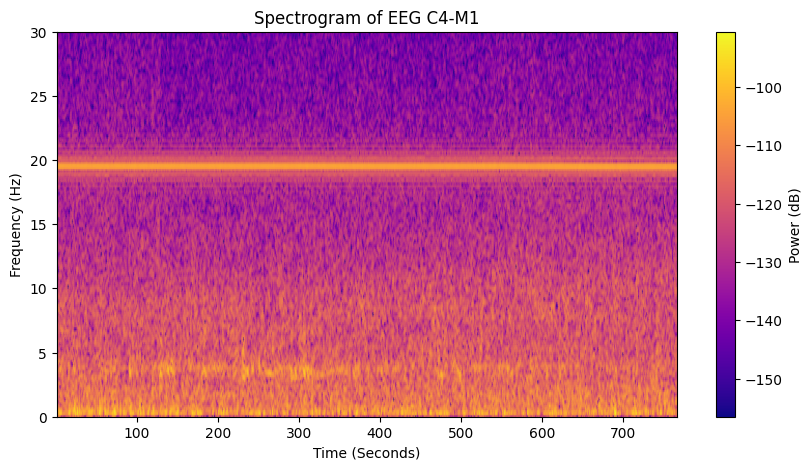

In [62]:
import numpy as np
import mne
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

# Load your EEG data file (example for SN001)
edf_file = r'C:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN001.edf'  # replace with your file path
raw = mne.io.read_raw_edf(edf_file, preload=True)

segment_data, times = raw.copy().pick_channels(['EEG C4-M1']).crop(tmin=0, tmax=300).get_data(return_times=True)
segment_data = segment_data.flatten()

# Calculate spectrogram
frequencies, times, Sxx = spectrogram(segment_data, fs=100, nperseg=256, noverlap=128, nfft=512)

# Convert to dB scale for better contrast
Sxx_dB = 10 * np.log10(Sxx + np.finfo(float).eps)

# Plot spectrogram
plt.figure(figsize=(10, 5))
plt.pcolormesh(times, frequencies, Sxx_dB, shading='gouraud', cmap='plasma')
plt.colorbar(label='Power (dB)')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (Seconds)')
plt.title('Spectrogram of EEG C4-M1')
plt.ylim(0, 30)  # Focus on 0-30 Hz range for EEG
plt.show()

In [68]:
import os
import mne
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

def calculate_sleep_efficiency(edf_file, annotation_file):
    # Load and preprocess EDF file
    raw = mne.io.read_raw_edf(edf_file, preload=True)
    raw.crop(tmin=150, tmax=raw.times[-1] - 150)
    raw.filter(0.5, 30, fir_design='firwin')
    raw.resample(100)
    
    # Load and process annotation file
    annotations_df = pd.read_csv(annotation_file)
    annotations_df.columns = ["Date", "Time", "Recording onset", "Duration", "Annotation", "Linked channel"]
    annotations_df['Recording onset'] = pd.to_numeric(annotations_df['Recording onset'], errors='coerce')
    annotations_df['Duration'] = pd.to_numeric(annotations_df['Duration'], errors='coerce')
    
    # Filter annotations to fit within the cropped data range and adjust onset
    total_duration = raw.times[-1] - 150 * 2
    filtered_annotations_df = annotations_df[
        (annotations_df['Recording onset'] >= 150) &
        (annotations_df['Recording onset'] <= total_duration)
    ].copy()
    filtered_annotations_df['Recording onset'] -= 150

    # Initialize sleep stage durations
    sleep_stage_durations = {"W": 0, "N1": 0, "N2": 0, "N3": 0, "R": 0}
    
    # Accumulate duration for each sleep stage
    for _, row in filtered_annotations_df.iterrows():
        stage = row['Annotation'].split()[-1]  # Extract the sleep stage (e.g., "W", "N1", "N2", "N3", "REM")
        if stage in sleep_stage_durations:
            sleep_stage_durations[stage] += row['Duration']

    # Calculate Sleep Efficiency
    total_time_in_bed = sum(sleep_stage_durations.values())  # Sum of all stage durations
    total_time_asleep = total_time_in_bed - sleep_stage_durations["W"]  # Exclude wake duration
    sleep_efficiency = (total_time_asleep / total_time_in_bed) * 100  # In percentage
    
    # Calculate the percentage of time spent in deep sleep (N3)
    total_time_deep_sleep = sleep_stage_durations["N3"]
    percentage_deep_sleep = (total_time_deep_sleep / total_time_in_bed) * 100  # In percentage

    return sleep_efficiency, percentage_deep_sleep



edf_file_sn001 = os.path.join(edf_dir, 'SN001.edf')
annotation_file_sn001 = os.path.join(annotation_dir, 'SN001_sleepscoring.txt')

edf_file_sn004 = os.path.join(edf_dir, 'SN004.edf')
annotation_file_sn004 = os.path.join(annotation_dir, 'SN004_sleepscoring.txt')

# Simulate multiple sleep efficiency and deep sleep percentage values for SN001 and SN004
# Replace these with real data if available
sleep_efficiencies = []
deep_sleep_percentages = []

# Example: Calculate these values for multiple recordings
for _ in range(5):  # Simulate for 5 recordings, adjust as per your data
    sleep_efficiency_sn001, deep_sleep_sn001 = calculate_sleep_efficiency(edf_file_sn001, annotation_file_sn001)
    sleep_efficiency_sn004, deep_sleep_sn004 = calculate_sleep_efficiency(edf_file_sn004, annotation_file_sn004)
    
    sleep_efficiencies.extend([sleep_efficiency_sn001, sleep_efficiency_sn004])
    deep_sleep_percentages.extend([deep_sleep_sn001, deep_sleep_sn004])

# Perform Pearson's Correlation
correlation, p_value = pearsonr(sleep_efficiencies, deep_sleep_percentages)

# Display results
print(f"Pearson Correlation Coefficient: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpret result
alpha = 0.05
if p_value < alpha:
    print("There is a significant correlation between sleep efficiency and the percentage of time spent in deep sleep.")
else:
    print("There is no significant correlation between sleep efficiency and the percentage of time spent in deep sleep.")


Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6566399  =      0.000 ... 25649.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3334667195.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3334667195.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7804927  =      0.000 ... 30487.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3334667195.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3334667195.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6566399  =      0.000 ... 25649.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3334667195.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3334667195.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7804927  =      0.000 ... 30487.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3334667195.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3334667195.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6566399  =      0.000 ... 25649.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3334667195.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3334667195.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7804927  =      0.000 ... 30487.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3334667195.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3334667195.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6566399  =      0.000 ... 25649.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3334667195.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3334667195.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7804927  =      0.000 ... 30487.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3334667195.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3334667195.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6566399  =      0.000 ... 25649.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3334667195.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3334667195.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7804927  =      0.000 ... 30487.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3334667195.py:9: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_17396\3334667195.py:9: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Pearson Correlation Coefficient: 1.0000
P-value: 0.0000
There is a significant correlation between sleep efficiency and the percentage of time spent in deep sleep.
